# Дискриминантный анализ

In [4]:
import numpy as np
import math
import itertools
import scipy.stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Постановка задачи
Построить и протестировать классификатор с использованием:
- модельных данных;
- данных из репозитория (https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/).

In [250]:
def print_points(points, ax):
    for c in points:
        ax.scatter(c[:,0], c[:,1], c[:,2], s=10, c=None, depthshade=True)
    
def print_data(data, filename):
    fig = plt.figure(figsize=plt.figaspect(0.25))
    for i in range(len(data)):
        ax = fig.add_subplot(1, len(data), i+1, projection='3d')
        print_points(data[i][0], ax)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title(data[i][1])
    fig.savefig("pictures/" + filename)
    plt.show()

In [251]:
def get_estimation_mu(D):
    return [sum(D[i])/len(D[i]) for i in range(len(D))]

def get_estimation_sigma(D, estimation_mu, n):
    dim = len(estimation_mu[0])
    deltas = [D[i]-estimation_mu[i] for i in range(len(D))]
    indexes = list(itertools.combinations_with_replacement(range(len(D[0][0])), 2))
    
    estimation_sigma = []
    for j in range(len(n)):
        tmp = np.zeros((dim, dim))
        for i in indexes:
            s = [deltas[j][k][i[0]]*deltas[j][k][i[1]] for k in range(n[j])]
            tmp[i] = sum(s)
        estimation_sigma.append(tmp - np.eye(dim) * tmp + tmp.T)
    return sum(estimation_sigma)/(sum(n)-2)

def get_alpha(mu, sigma):
    return np.dot(np.linalg.inv(sigma), mu[0]-mu[1])

def get_split_value(z, q):
    return z.mean() + math.log(q[1]/q[0])

def get_Mahalanobis_distance_estimate(z, s_z, n, p):
    D = (z[0]-z[1])*(z[0]-z[1])/s_z
    D_H = (sum(n)-p-3)/(sum(n)-2)*D - p*sum(n)/(n[0]*n[1])
    return D, D_H

def get_misclassification_probabilities(D_H, q):
    K = math.log(q[1]/q[0])
    p_2_1 = scipy.stats.norm.cdf((K - D_H/2) / math.sqrt(D_H))
    p_1_2 = scipy.stats.norm.cdf(-(K + D_H/2) / math.sqrt(D_H))
    return p_2_1, p_1_2

In [374]:
def classify(X, a, split_value):
    c = np.dot(X, a)
    mask = c >= split_value
    res = [[],[]]
    for i in range(len(mask)):
        if mask[i]:
            res[0].append(i)
        else:
            res[1].append(i) 
    return res

def do_research(mu, sigma, D, X, y, n):
    q = [n[i]/sum(n) for i in range(len(n))]
    alpha = get_alpha(mu, sigma)
#     print("alpha =", alpha)
    
    z = np.array([np.dot(D[i], alpha).mean() for i in range(len(n))])
#     print("z =", z)
    s_z = np.dot(np.dot(alpha, sigma), alpha)
#     print("s_z =", s_z)
    d, d_H = get_Mahalanobis_distance_estimate(z, s_z, n, len(D[0][0]))
    print("D =", d)
    print("D_H =", d_H)
    
    split_value = get_split_value(z, q)
#     print("split_value", split_value)
    
    res = classify(X, alpha, split_value)    
    table_X = np.zeros((2,2))
    table_X[0][1] = sum(y[res[0]] == 1)
    table_X[0][0] = len(res[0]) - table_X[0][1]
    table_X[1][0] = sum(y[res[1]] == 0)
    table_X[1][1] = len(res[1]) - table_X[1][0]
    
    tmp = np.vstack((D[0], D[1]))
    
    res = classify(tmp, alpha, split_value)
    table_D = np.zeros((2,2))
    table_D[0][1] = sum(np.array(res[0]) >= n[0])
    table_D[0][0] = len(res[0]) - table_D[0][1]
    table_D[1][0] = sum(np.array(res[1]) < n[0])
    table_D[1][1] = len(res[1]) - table_D[1][0]
    
    p = get_misclassification_probabilities(d_H, q)
    
    return table_X, table_D, p

### Классификатор с использованием модельных данных

In [375]:
def generate_data(mu, sigma, n, N):
    D = []
    for i in range(len(n)):
        vec = np.random.multivariate_normal(mu[i], sigma, n[i])
        D.append(vec)

    X, y = [], []
    for i in range(N):
        j = np.random.randint(0, 2)
        vec = np.random.multivariate_normal(mu[j], sigma, 1)
        X.append(vec[0])
        y.append(j)

    return D, np.array(X), np.array(y)

def do(mu, sigma, D, X, y, n):
#     table_X, table_D, p = do_research(mu, sigma, D, X, y, n)
#     print('Table for X:\n', table_X)
#     print('Table for D:\n', table_D)
#     print('P =', p)

#     print()
    estimation_mu = get_estimation_mu(D)
#     print("estimation_mu =", estimation_mu)
    estimation_sigma = get_estimation_sigma(D, estimation_mu, n)
#     print("estimation_sigma =", estimation_sigma)

    table_X, table_D, p = do_research(estimation_mu, estimation_sigma, D, X, y, n)
    print('Table for X:\n', table_X)
    print('Table for D:\n', table_D)
    print('P =', p)

In [376]:
mu_g = np.array([[-1, 0, 1,],
                 [2, 3, 4]])
sigma_g = [[1,1,1],
           [1,3,2],
           [1,2,4]]

mu_b = np.array([[1, 0.5, 0,],
                   [2, 1, 1]])
sigma_b = [[2,2,3],
           [2,5,6],
           [3,6,9]]

n = [1000, 1000]
N = 500

n_eq = [100, 250, 500, 750, 1000]
n_uneq = [[1000, 100], [1000, 200], [1000, 250], [1000, 500], [1000, 750]]

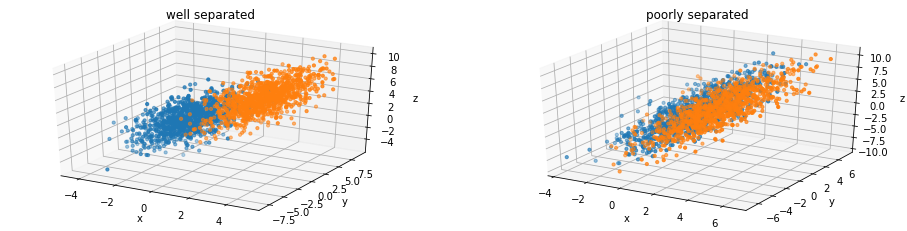

In [377]:
np.random.seed(42)
D_g, X_g, y_g = generate_data(mu_g, sigma_g, n, N)
D_b, X_b, y_b = generate_data(mu_b, sigma_b, n, N)
print_data([[D_g,'well separated'], [D_b,'poorly separated']], "eq_sets")

In [378]:
print("Well separated")
print("For equal n:")
for it in n_eq:
    print("\tn =", [it, it])
    do(mu_g, sigma_g, [D_g[0][0:it], D_g[1][0:it]] , X_g, y_g, [it, it])
    print()

print("For unequal n:")
for it in n_uneq:
    print("\tn =", it)
    do(mu_g, sigma_g, [D_g[0][0:it[0]], D_g[1][0:it[1]]] , X_g, y_g, it)
    print()

Well separated
For equal n:
	n = [100, 100]
D = 8.963253571169863
D_H = 8.72217774144926
Table for X:
 [[240.  18.]
 [ 23. 219.]]
Table for D:
 [[93.  6.]
 [ 7. 94.]]
P = (0.069882506206603, 0.069882506206603)

	n = [250, 250]
D = 9.748526773198318
D_H = 9.646225353333271
Table for X:
 [[243.  16.]
 [ 20. 221.]]
Table for D:
 [[234.  15.]
 [ 16. 235.]]
P = (0.060221285130741965, 0.060221285130741965)

	n = [500, 500]
D = 9.531112392380193
D_H = 9.480911541108128
Table for X:
 [[240.  19.]
 [ 23. 218.]]
Table for D:
 [[473.  33.]
 [ 27. 467.]]
P = (0.061834498642655625, 0.061834498642655625)

	n = [750, 750]
D = 9.485257736421772
D_H = 9.45192994540329
Table for X:
 [[241.  18.]
 [ 22. 219.]]
Table for D:
 [[705.  46.]
 [ 45. 704.]]
P = (0.06212222407114761, 0.06212222407114761)

	n = [1000, 1000]
D = 9.056036249021895
D_H = 9.03190604632115
Table for X:
 [[242.  19.]
 [ 21. 218.]]
Table for D:
 [[932.  71.]
 [ 68. 929.]]
P = (0.06646382472262083, 0.06646382472262083)

For unequal n:
	n

In [379]:
print("Poorly separated")
print("For equal n:")
for it in n_eq:
    print("\tn =", [it, it])
    do(mu_b, sigma_b, [D_b[0][0:it], D_b[1][0:it]] , X_b, y_b, [it, it])
    print()

print("For unequal n:")
for it in n_uneq:
    print("\tn =", it)
    do(mu_b, sigma_b, [D_b[0][0:it[0]], D_b[1][0:it[1]]] , X_b, y_b, it)
    print()

Poorly separated
For equal n:
	n = [100, 100]
D = 1.147543037102867
D_H = 1.0643603494846272
Table for X:
 [[166.  88.]
 [ 95. 151.]]
Table for D:
 [[72. 28.]
 [28. 72.]]
P = (0.3029833583568313, 0.3029833583568313)

	n = [250, 250]
D = 0.9355987823494489
D_H = 0.9040839326920236
Table for X:
 [[169.  79.]
 [ 92. 160.]]
Table for D:
 [[170.  70.]
 [ 80. 180.]]
P = (0.31724501759031065, 0.31724501759031065)

	n = [500, 500]
D = 0.7682436893373066
D_H = 0.7531645563139105
Table for X:
 [[164.  75.]
 [ 97. 164.]]
Table for D:
 [[330. 159.]
 [170. 341.]]
P = (0.33217135471899034, 0.33217135471899034)

	n = [750, 750]
D = 0.7463783294279417
D_H = 0.7363853298834078
Table for X:
 [[167.  75.]
 [ 94. 164.]]
Table for D:
 [[490. 252.]
 [260. 498.]]
P = (0.33393814844479097, 0.33393814844479097)

	n = [1000, 1000]
D = 0.7346419754797482
D_H = 0.727171220774083
Table for X:
 [[171.  78.]
 [ 90. 161.]]
Table for D:
 [[662. 344.]
 [338. 656.]]
P = (0.33491851886416, 0.33491851886416)

For unequal 

### Классификатор с использованием данных из репозитория

In [119]:
def load_data():
    f = open('data\german.data-numeric', 'r')
    data = []
    for line in f:
        vec = list(map(int, line.split()))
        data.append(vec)
    f.close()
    
    return np.array(data)

def sort_data(data, k):
    indexes_D = list(np.random.choice(len(data), k, replace=False))
    indexes_X = list(set(range(len(data))) - set(indexes_D))
    
    D = [[],[]]
    for elem in data[indexes_D]:
        if elem[-1] == 1:
            D[0].append(elem[0:-1])
        else:
            D[1].append(elem[0:-1])
    n = [len(D[0]), len(D[1])]
    
    X = data[indexes_X, 0:-1]
    y = data[indexes_X, -1]
    return D, X, y, n

In [676]:
k = 100
data = load_data()

D, X, y, n = sort_data(data, k)
print('n =', n)
estimation_mu = get_estimation_mu(D)
estimation_sigma = get_estimation_sigma(D, estimation_mu, n)

table_X, table_D, p = do_research(estimation_mu, estimation_sigma, D, X, y-1, n)
print('Table for X:\n', table_X)
print()
print('Table for D:\n', table_D)
print('P =', p)

n = [65, 35]
Table for X:
 [[518. 139.]
 [117. 126.]]

Table for D:
 [[58.  5.]
 [ 7. 30.]]
P = (0.11379481147802639, 0.3203668545919762)
